In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns

In [3]:
iris = load_iris()
X = iris.data
y = iris.target

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [5]:
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

In [6]:
class IrisData(Dataset):
    def __init__(self, X_train, y_train) -> None:
        super().__init__()
        self.X = torch.from_numpy(X_train)
        self.y = torch.from_numpy(y_train)
        self.y = self.y.type(torch.LongTensor)
        self.len = self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.len

In [7]:
iris_data = IrisData(X_train=X_train, y_train=y_train)
train_loader = DataLoader(dataset=iris_data, batch_size=32)

In [8]:
class MultiClassNet(nn.Module):
    def __init__(self, NUM_FEATURES, NUM_CLASSES, HIDDEN_FEATURES):
        super().__init__()
        self.lin1 = nn.Linear(NUM_FEATURES, HIDDEN_FEATURES)
        self.lin2 = nn.Linear(HIDDEN_FEATURES, NUM_CLASSES)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.lin1(x)
        x = torch.sigmoid(x)
        x = self.lin2(x)
        x = self.log_softmax(x)
        return x

In [9]:
NUM_FEATURES = iris_data.X.shape[1]
HIDDEN = 6
NUM_CLASSES = len(iris_data.y.unique())

In [10]:
model = MultiClassNet(
    NUM_FEATURES=NUM_FEATURES, NUM_CLASSES=NUM_CLASSES, HIDDEN_FEATURES=HIDDEN
)

In [11]:
criterion = nn.CrossEntropyLoss()

In [12]:
lr = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [13]:
NUM_EPOCHS = 100
losses = []
for epoch in range(NUM_EPOCHS):
    for x, y in train_loader:
        # initialize gradients
        optimizer.zero_grad()

        # forward pass
        y_hat_log = model(x)

        # calculate losses
        loss = criterion(y_hat_log, y)

        # calculate gradients

        loss.backward()
        # update parameters
        optimizer.step()

    losses.append(float(loss.data.detach().numpy()))

<Axes: >

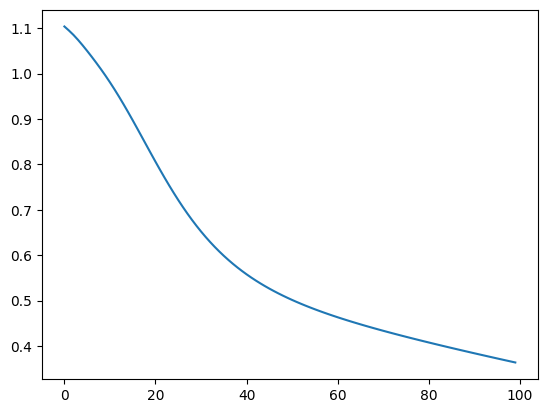

In [14]:
sns.lineplot(x=range(len(losses)), y=losses)

In [15]:
X_test_torch = torch.from_numpy(X_test)
with torch.no_grad():
    y_test_hat_softmax = model(X_test_torch)
    y_test_hat = torch.max(y_test_hat_softmax.data, 1)

In [16]:
accuracy_score(y_test, y_test_hat.indices)

0.9666666666666667

In [17]:
from collections import Counter

most_common_cnt = Counter(y_test).most_common()[0][1]
print(f"Naive Classifier: {most_common_cnt / len(y_test) * 100} %")

Naive Classifier: 43.333333333333336 %
